In [2]:
import torch
import numpy as np
import scipy
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Helper Functions:

def cosine_similarity(x1, x2, dim=1):
    return torch.nn.functional.cosine_similarity(torch.Tensor(x1), torch.Tensor(x2), dim=dim, eps=1e-8).numpy()

def multiple_sample_lineplot(array, *args, **kwargs):
    df = pd.DataFrame(array).reset_index(names="iteration")
    df = pd.melt(df, id_vars="iteration", var_name="sample_id")
    sns.lineplot(df, x="iteration", y="value", *args, **kwargs)
    
def gini(x):
    x = np.asarray(x)
    sorted_x = np.sort(np.abs(x))
    n = len(x)
    cumx = np.cumsum(sorted_x, dtype=float)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

In [4]:
# load gradients
filepath = "../logs/5ew_2024_09_17_20_21_43/ensemble/" 

# dynamically compute number of epochs by number of '.npz'-files
NO_EPOCHS = len([ _ for f in os.listdir(filepath) if f.endswith('.npz')]) - 1
STEP_SIZE = 20

# construct filenames based of NO_EPOCHS:
filenames = ["fake_sample_grads_epoch_0.npz"] +  ["fake_sample_grads_epoch_" + str(i*STEP_SIZE) + ".npz" for i in range(1, NO_EPOCHS+1)]

grads = []
for filename in filenames:
    with np.load(filepath + filename) as grad_file:
        grads.append(grad_file["arr_0"])
        
# dynamically retrieve number of discriminators from grads file
NO_DISCR = grads[0].shape[1]

# construct pair indices
pair_indices = np.triu_indices(NO_DISCR, k=1)
pair_indices = list(zip(pair_indices[0], pair_indices[1]))

In [5]:
grads[0].shape

(5000, 5, 262)

In [6]:
# load Discriminator-Output

filenames = ["Discr_Outs_epoch_0.csv"] +  ["Discr_Outs_epoch_" + str(i*STEP_SIZE) + ".csv" for i in range(1, NO_EPOCHS+1)]

discr_out = []
for filename in filenames:
    discr_out.append(pd.read_csv(filepath + filename, header=None))
    
discr_out = np.stack(discr_out, axis=0)

In [7]:
# Overview and Tensor shapes

grads = np.stack(grads, axis=0)
print("Gradients")
print("Epoch x Sample x Discriminator x Feature")
print(grads.shape)
print()

grads = np.stack(grads, axis=0)
print("Discriminator_Predictions")
print("Epoch x Sample x Discriminator")
print(discr_out.shape)
print()
print("  fake-label: 0, real-label: 0.634 (2 Samples Packed together)")


Gradients
Epoch x Sample x Discriminator x Feature
(25, 5000, 5, 262)

Discriminator_Predictions
Epoch x Sample x Discriminator
(25, 500, 5)

  fake-label: 0, real-label: 0.634 (2 Samples Packed together)


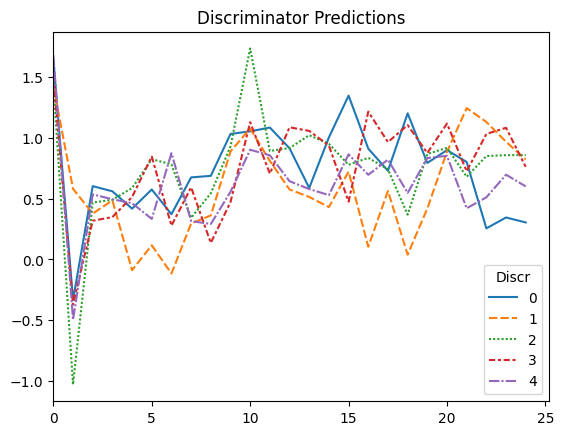

In [8]:
# Plot: Discriminator Predictions

mean_prediction = discr_out.mean(axis=1)
sns.lineplot(mean_prediction)
plt.title("Discriminator Predictions")
plt.legend(title="Discr")
plt.barh(y=0.634/2, width=NO_EPOCHS, height=0.001, )
plt.savefig(filepath + "../discr_predicts.pdf")
plt.show()

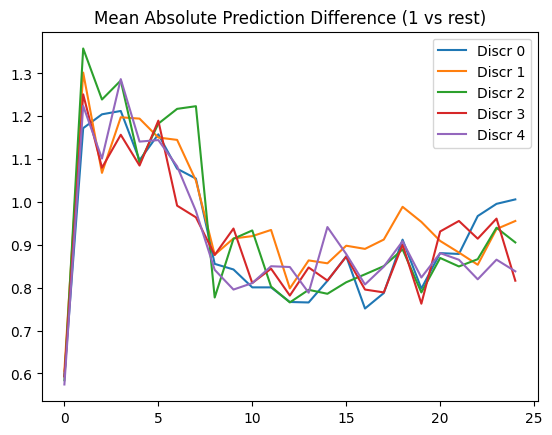

In [10]:
# Plot: 1vsrest Mean Prediction Difference

if NO_DISCR > 1:
    for i in range(NO_DISCR):
        mean_pred_diff = np.mean(
            [np.abs(discr_out[:,:,i] - discr_out[:,:,j]).mean(axis=1) for j in range(NO_DISCR)],
            axis=0)
        sns.lineplot(mean_pred_diff, label='Discr {}'.format(i))
        #sns.lineplot(pd.Series(mean_pred_diff).rolling(20).mean().values, label='Discr {}'.format(i))
        plt.title("Mean Absolute Prediction Difference (1 vs rest)")
        plt.legend
    
    plt.savefig(filepath + "../discr_difference.pdf")
    plt.show()

In [11]:
# Compute Magnitudes

magnitudes = np.abs(grads).mean(axis=1) # mean over samples
aggr_magnitudes = np.abs(grads.mean(axis=2)).mean(axis=1)

#test = grads[:, :, 1]

#print(grads.shape)
#print(magnitudes.shape)
#print(aggr_magnitudes.shape)
#print(test.reshape(*test.shape[:2],  -1).shape)

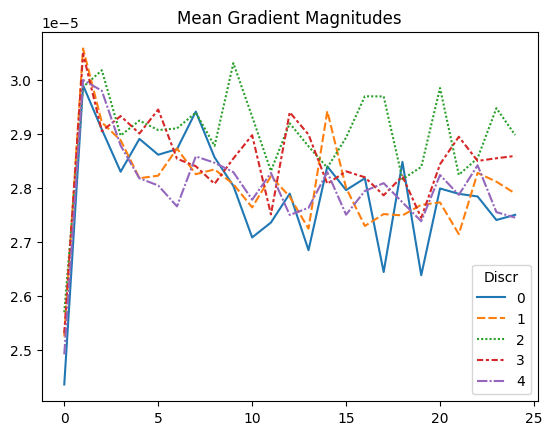

In [12]:
# Plot: Mean Gradient Magnitudes

sns.lineplot(magnitudes.mean(axis=2)) # mean over features
plt.title("Mean Gradient Magnitudes")
plt.legend(title="Discr")
plt.savefig(filepath + "../gradients_mean.pdf")
plt.show()

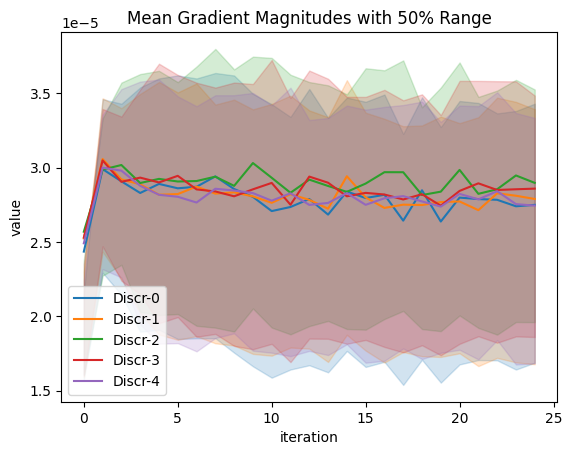

In [14]:
# Plot: Mean Gradient Magnitudes with Range

plt.title("Mean Gradient Magnitudes with 50% Range")
for i in range(NO_DISCR):
    multiple_sample_lineplot(magnitudes[:,i], errorbar=("pi", 50), label='Discr-{}'.format(i))
#add for aggregated Gradients
#multiple_sample_lineplot(aggr_magnitudes, errorbar=("pi", 50), linewidth=3, label='aggregated'.format(i))
plt.savefig(filepath + "../gradient_range.pdf")
plt.show()

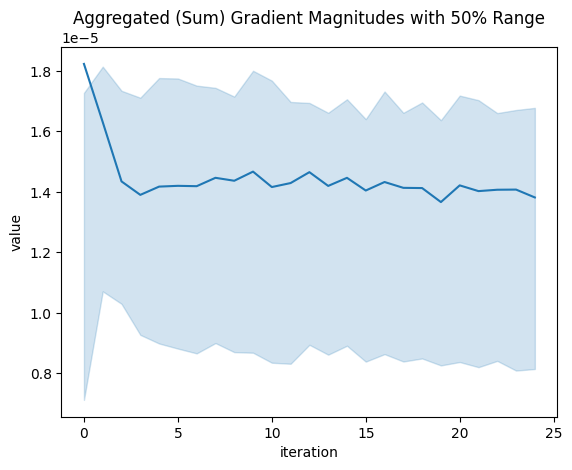

In [14]:
# Plot: Aggregated Gradient Magnitudes with Range

plt.title("Aggregated (Sum) Gradient Magnitudes with 50% Range")
# sum over discriminators, then absolute, then mean overfeatures
multiple_sample_lineplot(np.abs(grads.mean(axis=2)).mean(axis=1), errorbar=("pi", 50))
plt.savefig(filepath + "../aggr_gradient_range.pdf")
plt.show()

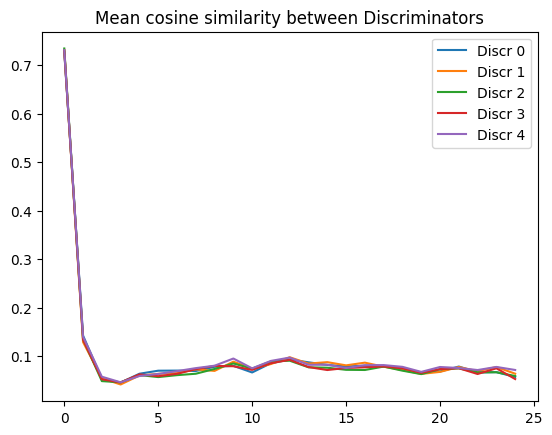

In [15]:
# Plot: 1vrest Mean Cosine Similarity

    
#compare Mean Cosine Similarity between pairs of Discriminator
if NO_DISCR > 1:
    for i in range(NO_DISCR):
        cs_current = np.mean(
            [cosine_similarity(grads[:, :, i], grads[:, :, j], dim=2) for j in range(NO_DISCR) if i != j],
            axis=0)
        sns.lineplot(pd.Series(cs_current.mean(axis=1)), label='Discr {}'.format(i))
        #sns.lineplot(pd.Series(cs_current.mean(axis=1)).rolling(20).mean().values, label='Discr {}'.format(i))

    plt.title("Mean cosine similarity between Discriminators")
    plt.legend
    plt.savefig(filepath + "../cosine_simil_mean.pdf")
    plt.show()


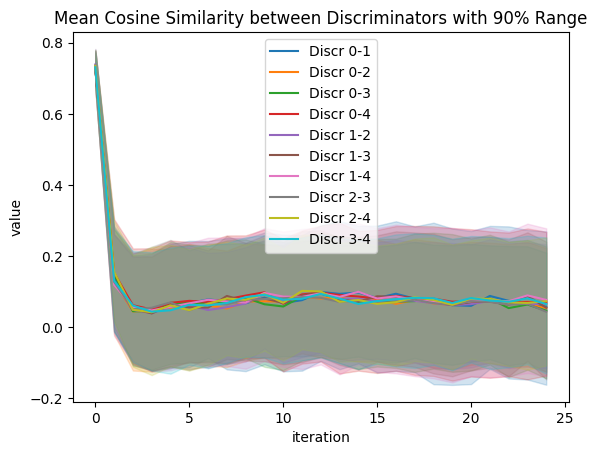

In [16]:
#compare Mean Cosine Similarity between pairs of Discriminator
if NO_DISCR > 1:
    cs={}
    for i,j in pair_indices:
        cs[i,j] = cosine_similarity(grads[:, :, i], grads[:, :, j], dim=2)
    
# Plot: Mean Cosine Similarity with Range
if NO_DISCR > 1:
    for i,j in pair_indices:
        multiple_sample_lineplot(cs[i,j], label='Discr {}-{}'.format(i,j), errorbar=("pi", 90))

    plt.title("Mean Cosine Similarity between Discriminators with 90% Range")
    plt.legend
    plt.savefig(filepath + "../cosine_simil_range.pdf")
    plt.show()

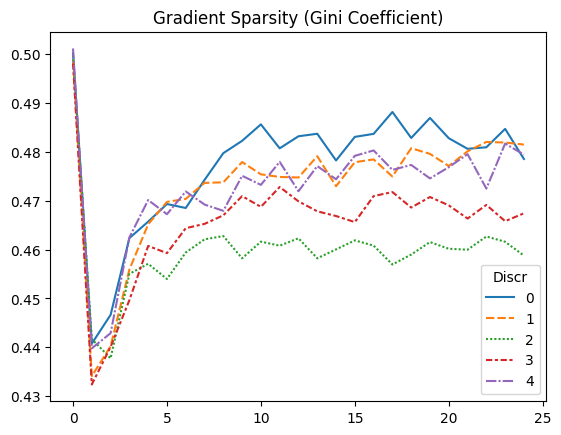

In [17]:
# Plot: Gini Coefficient:
shape = grads.shape
grads_reformatted = grads.transpose(0, 2, 1, 3).reshape(shape[0],shape[2],-1)
sns.lineplot(np.apply_along_axis(gini, arr=grads_reformatted, axis=-1))
plt.title("Gradient Sparsity (Gini Coefficient)")
plt.legend(title="Discr")
#plt.barh(y=0.634/2, width=NO_EPOCHS, height=0.001, )
plt.savefig(filepath + "../gini_coeff.pdf")
plt.show()

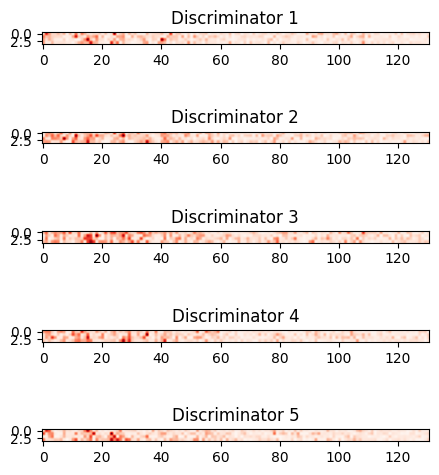

In [15]:
timestep = 10
sample_id = 2
PACCING = True
pac_size = 2

if PACCING:
    sample_id = list(range(sample_id, sample_id+pac_size))
    

fig, axs = plt.subplots(NO_DISCR, figsize=(5, 1*NO_DISCR + pac_size))


for discr in range(NO_DISCR):
    
    if PACCING:
        grads_stacked = np.column_stack([grads[timestep, sample_id, discr].flatten()[::2], 
                              grads[timestep, sample_id, discr].flatten()[1::2]]).T
        
        image_width = grads_stacked.shape[1]//2
        grads_stacked = np.vstack([grads_stacked[:,i*image_width:(i+1)*image_width] for i in range(pac_size)], )
    else:
        grads_stacked = np.column_stack([grads[timestep, sample_id, discr][::2], 
                              grads[timestep, sample_id, discr][1::2]]).T
        

    im1 = axs[discr].imshow(np.abs(grads_stacked), cmap="Reds")
    
    axs[discr].set_title(f"Discriminator {discr+1}")

    # Add colorbars
    #plt.colorbar(im1, ax=axs[discr], shrink=0.6)
    
plt.subplots_adjust(wspace=0.2, hspace=-0.3)
plt.tight_layout
plt.show()


## Deprecated

In [ ]:
# Plot: Mean Prediction Difference

if NO_DISCR > 1:
    for (i,j) in pair_indices:
        sns.lineplot(np.abs(discr_out[:,:,i] - discr_out[:,:,j]).mean(axis=1), label='Discr {}-{}'.format(i,j))
        plt.title("Mean Prediction Difference between Discriminators")
        plt.legend
    #plt.savefig(filepath + "../discr_difference.pdf")
    plt.show()

In [ ]:
#compare Mean Cosine Similarity between pairs of Discriminator
if NO_DISCR > 1:
    cs={}
    for i,j in pair_indices:
        cs[i,j] = cosine_similarity(grads[:, :, i], grads[:, :, j], dim=2)
        sns.lineplot(cs[i,j].mean(axis=1), label='Discr {}-{}'.format(i,j))

    plt.title("Mean cosine similarity between Discriminators")
    plt.legend
    #plt.savefig(filepath + "../cosine_simil_mean.pdf")
    plt.show()